In [1]:
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
import pandas as pd
import matplotlib.pyplot as plt
import asyncio
import textwrap
import bisect

In [2]:
# Parameters
# File name
file_name = 'karamazov'
# Max length a synced up string can be (in characters)
max_chunk_size = 300
# Width of a column in the .txt (in characters)
col_width = 22
# Spacing between the two columns in the .txt (in characters)
col_spacing = 5

In [3]:
with open(file_name + '_translation.txt', 'r') as translation_file:
    translation_text = translation_file.read()

with open(file_name + '_source.txt', 'r') as source_file:
    source_text = source_file.read()

In [4]:
# For project gutenberg files (Removing single new lines while keeping double new lines)
def replace_newlines(text):
    placeholder = 'PLACEHOLDER_UNIQUE_STRING'
    text = text.replace('\n\n', placeholder)
    text = text.replace('\n', ' ')
    text = text.replace(placeholder, '\n\n')
    return text

# source_text = replace_newlines(source_text)
translation_text = replace_newlines(translation_text)

In [5]:
'''
Langchain documents are created from the book using a text splitter to divide the texts 
into small chunks with large overlap in the hope of the vectors lining up more accurately

Then, the lists of documents are split into a list of lists with 1000 documents each because 
it is faster to ingest into the chroma database.
'''
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 100,
    chunk_overlap  = 50,
    add_start_index = True,
)

translation_docs = text_splitter.create_documents([translation_text])
source_docs = text_splitter.create_documents([source_text])
sublist_length = 1000
translation_docs_split = [translation_docs[i:i + sublist_length] for i in range(0, len(translation_docs), sublist_length)]
source_docs_split = [source_docs[i:i + sublist_length] for i in range(0, len(source_docs), sublist_length)]

In [6]:
'''
This embedding model converts the pieces of text into lists of floats (eg [-0.6, 200.4, 10.7])
which represent the semantic meaning of the encoded text

The benefit of this conversion is that you can now quantitatively compare the semantic meanings of texts.
In other words, you can mathematically discern how similar two texts are in meaning.

The benefit of this model is that it can do those mappings for multiple languages, so you can compare sentences between languages.
For the mathematicians, the multilingual model encodes the different languages into the same vector space.
'''
embeddings_model = SentenceTransformerEmbeddings(model_name="distiluse-base-multilingual-cased-v1")

In [7]:
# The source texts and embeddings are saved in a chromadb vector database. Note: This took me 5 min for 21,000 docs and 13 for 35,000.
i = 0
if 'vectordb' not in locals() and 'vectordb' not in globals():
    for docs in source_docs_split:
        i += 1
        print(str(i * sublist_length) + ' / ' + str(len(source_docs_split) * sublist_length))
        vectordb = Chroma.from_documents(documents=docs, embedding=embeddings_model)

1000 / 35000
2000 / 35000
3000 / 35000
4000 / 35000
5000 / 35000
6000 / 35000
7000 / 35000
8000 / 35000
9000 / 35000
10000 / 35000
11000 / 35000
12000 / 35000
13000 / 35000
14000 / 35000
15000 / 35000
16000 / 35000
17000 / 35000
18000 / 35000
19000 / 35000
20000 / 35000
21000 / 35000
22000 / 35000
23000 / 35000
24000 / 35000
25000 / 35000
26000 / 35000
27000 / 35000
28000 / 35000
29000 / 35000
30000 / 35000
31000 / 35000
32000 / 35000
33000 / 35000
34000 / 35000
35000 / 35000


In [8]:
# Creates a df with the translation docs
split_texts = [doc.page_content for doc in translation_docs]
split_indices = [doc.metadata['start_index'] for doc in translation_docs]
df = pd.DataFrame({'text': split_texts, 'index': split_indices})

In [9]:
async def async_find_closest_verse(vectordb, query):
    matches = await vectordb.asimilarity_search_with_relevance_scores(query, k=2)
    return matches[0][0].page_content, matches[0][0].metadata['start_index'], matches[0][1], matches[1][1]

async def apply_async_function(row):
    return await async_find_closest_verse(vectordb, row['text'])

async def main(df):
    tasks = [apply_async_function(row) for _, row in df.iterrows()]
    results = await asyncio.gather(*tasks)
    return results

In [10]:
'''
For each row in df, this finds the source substring most similar to that query, its index, its similarity score, and 
the similarity score of the next best match.

This took 6 minutes for two texts with roughly 35,000 subdocs each.

You may receive the error: UserWarning: Relevance scores must be between 0 and 1. I have paid this no mind.
'''
translation_length = len(translation_docs)
source_length = len(source_docs)
all_results = await main(df)
df_result = pd.DataFrame(all_results, columns=['match_text', 'match_index', 'match_score', 'next_best_match_score'])
df[['match_text', 'match_index', 'match_score', 'next_best_match_score']] = df_result
df['match_index'] = df['match_index'].astype('int64')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain/vectorstores/base.py:254: UserWarning: Relevance scores must be between 0 and 1, got [(Document(page_content='Иван, на старого мозгляка. Я знаю, что ты не любишь меня, только все-таки не сердись. Не за что', metadata={'start_index': 319269}), 0.010276514599288356), (Document(page_content='декламирует? Разве я не декламирую? А ведь искренен же я, искренен. Что же касается Ивана, то ведь', metadata={'start_index': 275377}), -0.005502169665129175)]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain/vectorstores/base.py:254: UserWarning: Relevance scores must be between 0 and 1, got [(Document(page_content='голову себе, а затем, найдя какую-то тряпку, окунул ее в воду и приложил к голове Лягавого. Сторож', metadata={'start_index': 895030}), -0.014835336386775477), (Document(page_content='подводя к нему Митю, — я ему давеча головку расчесывала; во

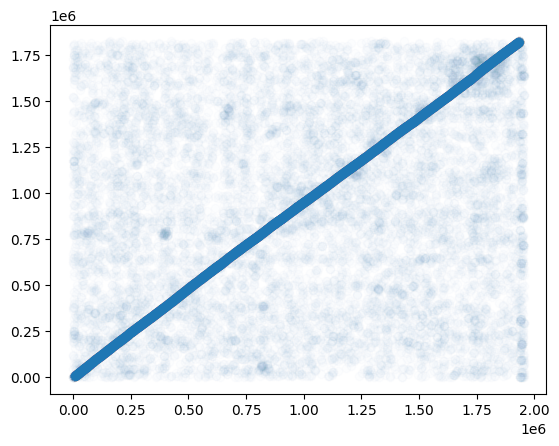

In [11]:
# For each subdoc in the translated text, its index is mapped against the index of its best match.
plt.scatter(
    df['index'], 
    df['match_index'],
    marker='o', 
    alpha=0.01
)
plt.show()

In [12]:
'''
The source and translation subdocs are paired, in the order of the absolute difference between the best 
and next best similarity scores. The pairs are only added if they don't contradict any of the 
previous index parings.
'''
def filter_and_sort_rows(df):
    sorted_df = df.sort_values(by='abs_diff', ascending=False)
    accepted_rows = []
    rejected_rows = []
    indices = []         
    match_indices = []   
    for _, row in sorted_df.iterrows():
        idx_position = bisect.bisect_left(indices, row['index'])
        match_idx_position = bisect.bisect_left(match_indices, row['match_index'])
        if (match_idx_position == len(match_indices) or match_indices[match_idx_position] != row['match_index']) and idx_position == match_idx_position:
            indices.insert(idx_position, row['index'])
            match_indices.insert(match_idx_position, row['match_index'])
            accepted_rows.append(row)
        else:
            rejected_rows.append(row)

    return pd.DataFrame(accepted_rows), pd.DataFrame(rejected_rows)

df['abs_diff'] = abs(df['match_score'] - df['next_best_match_score'])
sorted_df, unsorted_df = filter_and_sort_rows(df)
sorted_tuples = [(row['index'], row['match_index'], row['text'], row['match_text']) for _, row in sorted_df.sort_values(by='abs_diff', ascending=False).iterrows()]


In [13]:
# Subdoc pairs are merged into larger ones if they'll become more even and not exceed the max subdoc length (300).
def calculate_gaps(lst):
    return [lst[i+1] - lst[i] for i in range(len(lst)-1)]

def should_remove(i, gaps1, gaps2, max_chunk_size=300):
    current_gap_diff1 = abs(gaps1[i] - gaps2[i])
    current_gap_diff2 = abs(gaps1[i+1] - gaps2[i+1])
    combined_gap1 = gaps1[i] + gaps1[i+1]
    combined_gap2 = gaps2[i] + gaps2[i+1]
    new_gap_diff = abs(combined_gap1 - combined_gap2)
    return (new_gap_diff < current_gap_diff1) and (new_gap_diff < current_gap_diff2) and (combined_gap1 <= max_chunk_size and combined_gap2 <= max_chunk_size)

def remove_indices(lst1, lst2):
    gaps1 = calculate_gaps(lst1)
    gaps2 = calculate_gaps(lst2)
    i = 0
    while i < len(gaps1) - 1:
        if should_remove(i, gaps1, gaps2, max_chunk_size):
            del lst1[i+1]
            del lst2[i+1]
            del gaps1[i+1]
            del gaps2[i+1]
        else:
            i += 1
            
    return lst1, lst2

translation_indices = sorted([i[0] for i in sorted_tuples])
source_indices = sorted([i[1] for i in sorted_tuples])
translation_indices, source_indices = remove_indices(translation_indices, source_indices)

In [14]:
'''
Lists of strings are created based on the sorted indices and formatted to a .txt and .html file
The txt file is easier for an e-reader to render. It creates two pseudocolumns by padding whitespace between the two columns.
The html file creates many small tables of two columns, separated by kindle's pagebreak, so that the kindle doesn't shut down 
trying to dynamically render the whole thing. This adds the benefit of being able to change the font size and keeping the columns.
The small drawback is that there will be random page breaks every 300 vectors.
'''
def order_and_create_strings(input_string, indices):
    sorted_indices = sorted(indices)
    substrings = []
    for i in range(len(sorted_indices)):
        start_index = sorted_indices[i]
        if i < len(sorted_indices) - 1:
            end_index = sorted_indices[i + 1]
        else:
            end_index = len(input_string)

        substring = input_string[start_index:end_index]
        substrings.append(substring)

    return substrings

# The kindle will use different fonts for the english and russian texts when only one of them are present in a line.
# The --A-- ensures that every line will contain an english and russian character, making the font consistent.
def save_two_lists_as_txt_cols(list1, list2, max_width, col_buffer, filename='output.txt'):
    with open(filename, 'w') as file:
        for l1, l2, in zip(list1, list2):
            l1_wrapped = textwrap.wrap(l1, max_width)
            l2_wrapped = textwrap.wrap(l2, max_width)
            max_length = max(len(l1_wrapped), len(l2_wrapped))
            while len(l1_wrapped) < max_length:
                l1_wrapped.append('')
            while len(l2_wrapped) < max_length:
                l2_wrapped.append('')
            for text1, text2 in zip(l1_wrapped, l2_wrapped):
                file.write(text1.ljust(max_width + col_buffer) + text2 + '\n')
            file.write('\n')

def generate_html(list1, list2, filename):
    html_lines = [
        "<html>",
        "<head>",
        "<meta charset='UTF-8'>",
        "<style>",
        "td { width: 50%; vertical-align: top; }",
        "p.page-break { page-break-before: always; }",
        "</style>",
        "</head>",
        "<body>"
    ]
    for i, (item1, item2) in enumerate(zip(list1, list2)):
        if i % 300 == 0:
            if i > 0: 
                html_lines.append("</table></div>")
                html_lines.append('<p class="page-break"><hr style="width: 0%;" /></p>')
            html_lines.append("<div><table>")
        
        html_lines.append("<tr><td>{}</td><td>{}</td></tr>".format(item1, item2))

    html_lines.extend([
        "</table></div>",
        "<div><table></table></div>",
        "</body>",
        "</html>"
    ])
    with open(filename, "w", encoding="utf-8") as f:
        f.write("\n".join(html_lines))
    
def save_texts_as_cols(translation_text, source_text, translation_indices, source_indices, filename='output', source_on_left=True):
    if source_on_left:
        list1 = order_and_create_strings(source_text, source_indices)
        list2 = order_and_create_strings(translation_text, translation_indices)
    else:
        list1 = order_and_create_strings(translation_text, translation_indices)
        list2 = order_and_create_strings(source_text, source_indices)

    generate_html(list1, list2, filename + '.html')
    save_two_lists_as_txt_cols(list1, list2, col_width, col_spacing, filename=filename + '.txt')


save_texts_as_cols(translation_text, source_text, translation_indices, source_indices, file_name, False)